**4. CC_to_minF_scipy: 	Pruned_clique_complex -> Knill’s min F from scipy P**

Explore phase transitions for free energy by changing temperature and obtaining minimizing P.
-	Free energy vs temp for at least two probability strategies (scipy minimization and counting occurrences?)
-	If we may have bifurcation, one need to do several copies/simulations for the same network/brain
-	Compute this in a random graph, a scale free graph (similar size as brain)
-	Compute in a fmri based in mut info
-	Compute in structural connector (see dropbox Fernando sent - see Jupiter notes).

In [1]:
# Import libraries
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
import glob

C:\Users\cyril\AppData\Local\Temp\ipykernel_20776\3735499538.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Import external background functions
%run background_functions.py

In [3]:
# Define shannon entropy function
def shannon_entropy(probabilities):
    # Remove any zero probabilities to avoid log(0) issues
    probabilities = probabilities[probabilities != 0]
    return -np.sum(probabilities * np.log2(probabilities))

# Internal energy function
def energy_function(x, Q):
    return x.T @ Q @ x

# Free energy function
def free_energy_function(x, Q, t):
    entropy_term = - np.sum(x * np.log2(np.maximum(x, 1e-10)))  # Avoid log(0), changed to np.log2 to improve speed.
    return t*(x.T @ Q @ x) - (1-t) * entropy_term

# Generate the matrix L^-1 as required by Knill
def generate_inverse_connectivity_matrix(clique_complex):
    # Initialize the matrix
    size = len(clique_complex)
    matrix = np.zeros((size, size))

    # Fill the matrix
    for i in range(0, len(clique_complex)):
        for j in range(0, len(clique_complex)):
            if clique_complex[i].intersection(clique_complex[j]):
                matrix[i, j] = 1

    # Compute the inverse connectivity matrix
    inverse_connectivity_matrix = np.linalg.inv(matrix)

    return matrix, inverse_connectivity_matrix

# Find the minimum free energy for a given clique complex
def complete_f_generator_scipy(clique_complex, t):
    Q = generate_inverse_connectivity_matrix(clique_complex)[1]

    # Optimization settings
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = [(1e-10, None) for _ in range(len(Q))]
    x0 = np.full(len(Q), 1/len(Q))  # Initial guess

    # Store the latest optimized x0 and all free energies during minimization
    latest_x0 = None
    all_values = []

    # Callback function to collect values during minimization
    def callback(x):
        all_values.append(free_energy_function(x, Q, t))

    #for t in t_values:
    #    result = minimize(objective, x0, args=(Q, t), method='SLSQP', constraints=cons, bounds=bounds)
    #    minimized_values.append(result.fun)
    #    latest_x0 = result.x  # Update the latest optimized x0

    result = minimize(free_energy_function, x0, args=(Q, t), method='SLSQP', constraints=cons, bounds=bounds, callback=callback)
    return [result.fun, result.x]

def complete_f_generator(clique_complex):
    matrix, inverse_connectivity_matrix = generate_inverse_connectivity_matrix(clique_complex)

    # Generate maximum shannon entropy from uniform distribution
    n = len(inverse_connectivity_matrix)
    p_Smax = np.ones(n) / n
    max_entropy_value = shannon_entropy(p_Smax)

    # Generate minimum internal energy from analytical solution
    min_energy_probabilities = (np.inner(matrix,[1]*len(matrix)))/np.sum(matrix)
    min_energy_value = energy_function(min_energy_probabilities, inverse_connectivity_matrix)

    # Generate minimum free energy by custom optimisation
    f_list = []
    temperature_list = np.arange(0, 1, 0.1)

    for temperature in temperature_list:
        f = complete_f_generator_scipy(clique_complex, temperature)[0]
        f_list.append(f)

    return f_list, temperature_list, min_energy_value, max_entropy_value

In [4]:
############################################################ GENERATE PROBABILITY DISTRIBUTION ################################
# Define probability generator
def generate_probability_list(clique_complex, distribution_type='uniform'):
    if distribution_type == 'uniform':
        # Generate a list of random numbers
        probabilities = np.random.rand(len(clique_complex))

    elif distribution_type == 'custom':
        # Sample from a clique based distribution
        probabilities = nodes_probabilities(clique_complex)[1]

    else:
        raise ValueError("Invalid distribution_type. Supported types: 'uniform', 'custom'")

    # Ensure all values are positive (abs) and normalize to sum to 1
    probabilities = np.abs(probabilities).astype(float)  # Convert to float
    probabilities /= probabilities.sum()

    return probabilities

# Generate a probability list according to the clique_complex
def nodes_probabilities(clique_complex, distribution_type='uniform'):

    clique_dict = {}
    
    # Create a dictionary to group sets by their length
    sets_by_length = defaultdict(list)

    # Group sets by length
    for s in clique_complex:
        sets_by_length[len(s)].append(s)

    # Convert the dictionary values to lists
    result = list(sets_by_length.values())

    # Create empty list
    probabilities_clique_complex = []

    # Generate probability list per clique dimension and add
    probabilities_nodes = generate_probability_list(clique_complex, distribution_type)

    # Normalise the probability list for all clique dimensions together
    probabilities_nodes = np.abs(probabilities_nodes).astype(float)  # Convert to float
    probabilities_nodes /= probabilities_nodes.sum()

    for i in range(0, len(result[0])):
        clique_dict[clique_complex[i]]=probabilities_nodes[i]

    for clique in clique_complex:
        
        # Convert set to tuple and obtain all possible combinations with length smaller than the original set
        combinations_in_clique = [set(combination) for r in range(1, len(clique)) for combination in combinations(tuple(clique), r)]

        prior_element_prob = 1

        for element in combinations_in_clique:
            element_prob = clique_dict[frozenset(element)]  # to convert the set element into a string, so it is interpretable for dictionary
            prior_element_prob *= element_prob

        posterior_element_prob = prior_element_prob * np.random.rand() # Use a uniform distribution to sample the probability of each simplex

        clique_dict[frozenset(clique)]=posterior_element_prob

    probabilities_clique_complex = list(clique_dict.values())

    # Normalise so the sum equals 1, since probability distribution
    probabilities_clique_complex = np.abs(probabilities_clique_complex).astype(float)  # Convert to float
    probabilities_clique_complex /= probabilities_clique_complex.sum()

    return result, probabilities_clique_complex

############################################################ MINIMISE F #######################################################
# Define customised optimisation for energy
def free_energy_minimisation(clique_complex, matrix, num_iterations, temperature):
    current_probabilities = generate_probability_list(clique_complex, 'custom')
    current_value = free_energy_function(current_probabilities, matrix, temperature)
    history = []

    for _ in range(num_iterations):

        # Generate a new set of probabilities
        new_probabilities = generate_probability_list(clique_complex, 'custom')

        # Evaluate the entropy of the new set of probabilities
        new_value = free_energy_function(new_probabilities, matrix, temperature)

        # Accept the new set of probabilities if its entropy is greater
        if new_value < current_value:
            current_probabilities = new_probabilities
            current_value = new_value

        history.append(current_value)

    return history, current_probabilities

In [5]:
# Import data
#matrix = np.genfromtxt('1000_Functional_Connectomes\Connectivity matrices\AveragedMatrix.txt')
matrix = np.genfromtxt('1000_Functional_Connectomes\Connectivity matrices\Baltimore_5568_connectivity_matrix_file.txt')

In [6]:
# Define desired settings
cutoff=0.7 # Value between 0 and 1. Values below this value are set to zero. Becomes obsolete after including phase randomisation
max_dim=4

In [5]:
# Compute the clique complex and Euler Characteristic
%time euler_characteristic, clique_complex = compute_euler(matrix,cutoff,max_dim)

CPU times: total: 0 ns
Wall time: 4.06 ms


In [6]:
%time f_list, temperature_list, min_energy_value, max_entropy_value = complete_f_generator(clique_complex)

c:\Users\cyril\anaconda3\envs\TDA_danillo\lib\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
c:\Users\cyril\anaconda3\envs\TDA_danillo\lib\site-packages\scipy\optimize\_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
c:\Users\cyril\anaconda3\envs\TDA_danillo\lib\site-packages\scipy\optimize\_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


CPU times: total: 5.69 s
Wall time: 27.7 s


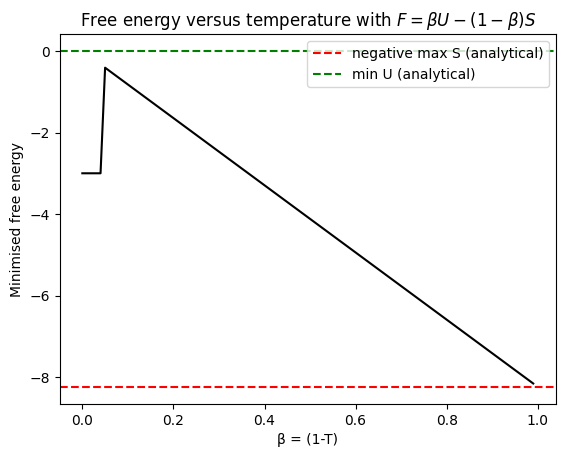

In [7]:
plt.plot(temperature_list, f_list, color='black')
plt.title('Free energy versus temperature with $F= β U - (1-β) S$')
plt.ylabel('Minimised free energy')
plt.xlabel('β = (1-T)')
plt.axhline(y=-max_entropy_value, color='r', linestyle='--', label='negative max S (analytical)')
plt.axhline(y=min_energy_value, color='g', linestyle='--', label='min U (analytical)')
plt.legend() 
plt.show()

In [10]:
path = glob.glob('1000_Functional_Connectomes\Connectivity matrices\*.txt')
cutoff=0.6 # Value between 0 and 1. Values below this value are set to zero. Becomes obsolete after including phase randomisation
max_dim=4
f_list_files = []
min_energy_values = []
max_entropy_values = []

for file in path[1:10]:
    matrix = np.genfromtxt(file)
    euler_characteristic, clique_complex = compute_euler(matrix,cutoff,max_dim)
    print(len(clique_complex))
    f_list, temperature_list, min_energy_value, max_entropy_value = complete_f_generator(clique_complex)
    f_list_files.append(f_list)
    min_energy_values.append(min_energy_value)
    max_entropy_values.append(max_entropy_value)

439
660
1454


KeyboardInterrupt: 

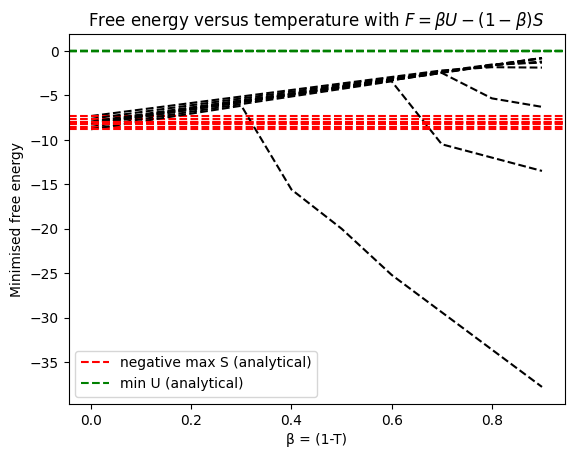

In [8]:
for i in range(0, len(f_list_files)):
    plt.plot(temperature_list, f_list_files[i], color='black', linestyle='--')
    plt.axhline(y=-max_entropy_values[i], color='r', linestyle='--')
    plt.axhline(y=min_energy_values[i], color='g', linestyle='--')
plt.axhline(y=-max_entropy_values[i], color='r', linestyle='--', label='negative max S (analytical)')
plt.axhline(y=min_energy_values[i], color='g', linestyle='--', label='min U (analytical)')
plt.title('Free energy versus temperature with $F= β U - (1-β) S$')
plt.ylabel('Minimised free energy')
plt.xlabel('β = (1-T)')
plt.legend() 
plt.show()

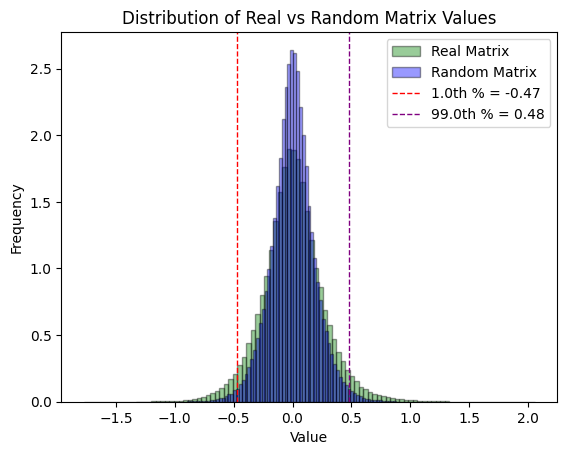

In [68]:
# Import the stored PR and real time series to compare their distribution
timeseries_REAL=pd.read_csv('TimeSeries_REAL\REST1\REAL_100206_rfMRI_REST1_Atlas_MSMAll_hp2000_clean_Schaefer2018_100Parcels_7Networks_Tian_Subcortex_S1_3T.txt',sep='\t',header=None)
timeseries_PR=pd.read_csv('TimeSeries_PR\REST1\PR_100206_rfMRI_REST1_Atlas_MSMAll_hp2000_clean_Schaefer2018_100Parcels_7Networks_Tian_Subcortex_S1_3T.txt',sep='\t',header=None)

# Flatten the matrices
real_corr_flat = np.array(timeseries_REAL).flatten()
random_corr_flat = np.array(timeseries_PR).flatten()

# Plot the distribution of correlation values for real vs random data
plt.hist(real_corr_flat, density=True, bins=100, label='Real Matrix', alpha=0.4, color='green', edgecolor='black')
plt.hist(random_corr_flat, density=True, bins=100, label='Random Matrix', alpha=0.4, color='blue', edgecolor='black')

# Calculate percentiles
q010 = np.quantile(random_corr_flat, 0.010)
q990 = np.quantile(random_corr_flat, 0.990)

# Draw red dotted lines at the 1.0th and 99.0th percentiles
plt.axvline(q010, color='red', linestyle='--', linewidth=1, label=f'1.0th % = {q010:.2f}')
plt.axvline(q990, color='purple', linestyle='--', linewidth=1, label=f'99.0th % = {q990:.2f}')

# Add legend to the plot
plt.legend()

# Optional: Add titles and labels
plt.title('Distribution of Real vs Random Matrix Values')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()

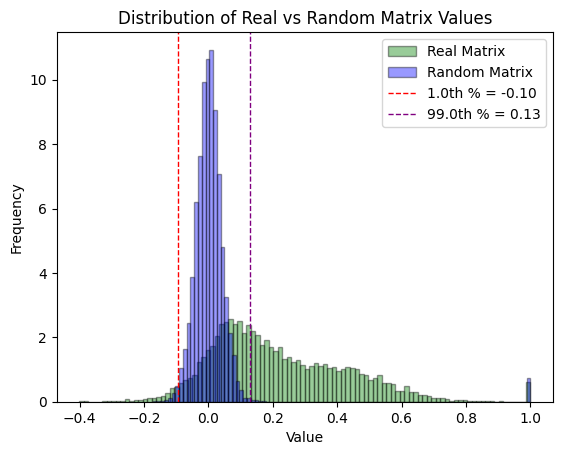

In [40]:
# Import the stored PR and real time series to compare their distribution
timeseries_REAL=pd.read_csv('TimeSeries_REAL\REST1\REAL_100206_rfMRI_REST1_Atlas_MSMAll_hp2000_clean_Schaefer2018_100Parcels_7Networks_Tian_Subcortex_S1_3T.txt',sep='\t',header=None)
timeseries_PR=pd.read_csv('TimeSeries_PR\REST1\PR_100206_rfMRI_REST1_Atlas_MSMAll_hp2000_clean_Schaefer2018_100Parcels_7Networks_Tian_Subcortex_S1_3T.txt',sep='\t',header=None)

# Generate pearson correlation matrix from array
real_corr=timeseries_REAL.T.corr().to_numpy()
random_corr=timeseries_PR.T.corr().to_numpy()

# Flatten the matrices
real_corr_flat = real_corr.flatten()
random_corr_flat = random_corr.flatten()

# Plot the distribution of correlation values for real vs random data
plt.hist(real_corr_flat, density=True, bins=100, label='Real Matrix', alpha=0.4, color='green', edgecolor='black')
plt.hist(random_corr_flat, density=True, bins=100, label='Random Matrix', alpha=0.4, color='blue', edgecolor='black')

# Calculate percentiles
q010 = np.quantile(random_corr_flat, 0.010)
q990 = np.quantile(random_corr_flat, 0.990)

# Draw red dotted lines at the 1.0th and 99.0th percentiles
plt.axvline(q010, color='red', linestyle='--', linewidth=1, label=f'1.0th % = {q010:.2f}')
plt.axvline(q990, color='purple', linestyle='--', linewidth=1, label=f'99.0th % = {q990:.2f}')

# Add legend to the plot
plt.legend()

# Optional: Add titles and labels
plt.title('Distribution of Real vs Random Matrix Values')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [82]:
import numpy as np

# Example matrices
random_matrix = random_corr  # Random matrix
real_matrix = real_corr  # Real matrix, replace with your actual real matrix

# Compute the 2.5th and 97.5th percentiles of the random matrix
q025 = np.quantile(random_matrix, 0.010)
q975 = np.quantile(random_matrix, 0.990)

# Create a mask for elements in the real matrix that are NOT between q025 and q975
mask = (real_matrix < q025) | (real_matrix > q975)
#mask = (real_matrix > q975)

pruned_matrix = np.where(mask, real_matrix, 0)

print(pruned_matrix)  # Adjust as needed for your inspection

[[1.         0.16536556 0.15758851 ... 0.25248465 0.23382147 0.24995966]
 [0.16536556 1.         0.         ... 0.         0.         0.        ]
 [0.15758851 0.         1.         ... 0.14015591 0.1416177  0.13303256]
 ...
 [0.25248465 0.         0.14015591 ... 1.         0.56883272 0.54148824]
 [0.23382147 0.         0.1416177  ... 0.56883272 1.         0.54287107]
 [0.24995966 0.         0.13303256 ... 0.54148824 0.54287107 1.        ]]


In [92]:
matrix = pruned_matrix
cutoff = 0.6
max_dim = 3
euler_characteristic, clique_complex = compute_euler(matrix,cutoff,max_dim)

In [93]:
len(clique_complex)

627

In [61]:
# Import libraries
import numpy as np

# Generate the matrix L^-1 as required by Knill
def generate_inverse_connectivity_matrix(clique_complex):

    # Initialize the matrix
    size = len(clique_complex)
    matrix = np.eye(size)

    # Fill the matrix
    for i in range(0, len(clique_complex)):
        for j in range(0, len(clique_complex)):
            if clique_complex[i].intersection(clique_complex[j]) and i!=j:
                matrix[i, j] = 1

    print(matrix)

    # Compute the inverse
    inverse_connectivity_matrix = np.linalg.inv(matrix)

    return inverse_connectivity_matrix

In [67]:
Knill_example = [{2,3},{1},{1,2},{2},{3},{3,4,5}]

print(generate_inverse_connectivity_matrix(Knill_example))

[[1. 0. 1. 1. 1. 1.]
 [0. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0.]
 [1. 0. 1. 1. 0. 0.]
 [1. 0. 0. 0. 1. 1.]
 [1. 0. 0. 0. 1. 1.]]


LinAlgError: Singular matrix

In [59]:
# Two clique complexes with 20 nodes, 78 edges and 26 triangles. The pairs are generated from random combinations of the nodes and the triangles from random combinations of the pairs.
Random_data_complex_singular = [{11, 4, 20}, {2, 18, 5}, {9, 13, 6}, {11, 13, 14}, {1, 2, 15}, {2, 19, 14}, {16, 10, 12}, {2, 10, 15}, {17, 18, 11}, {19, 4, 20}, {17, 18, 3}, {8, 10, 13}, {1, 5, 7}, {16, 19, 14}, {16, 2, 15}, {16, 15, 7}, {9, 11, 7}, {8, 10, 6}, {17, 19, 20}, {9, 4, 14}, {9, 13, 17}, {2, 19, 5}, {8, 11, 6}, {12, 13, 15}, {16, 10, 4}, {11, 12, 7}, {11, 4}, {4, 20}, {11, 20}, {2, 5}, {2, 18}, {18, 5}, {9, 6}, {13, 6}, {9, 13}, {11, 13}, {11, 14}, {13, 14}, {1, 2}, {1, 15}, {2, 15}, {2, 14}, {2, 19}, {19, 14}, {10, 12}, {16, 10}, {16, 12}, {2, 10}, {2, 15}, {10, 15}, {17, 11}, {18, 11}, {17, 18}, {19, 4}, {4, 20}, {19, 20}, {17, 3}, {18, 3}, {17, 18}, {8, 10}, {8, 13}, {10, 13}, {1, 5}, {1, 7}, {5, 7}, {16, 14}, {19, 14}, {16, 19}, {2, 15}, {16, 2}, {16, 15}, {15, 7}, {16, 7}, {16, 15}, {9, 7}, {11, 7}, {9, 11}, {8, 6}, {10, 6}, {8, 10}, {17, 19}, {17, 20}, {19, 20}, {9, 4}, {4, 14}, {9, 14}, {9, 13}, {9, 17}, {17, 13}, {2, 5}, {2, 19}, {19, 5}, {8, 6}, {11, 6}, {8, 11}, {12, 13}, {12, 15}, {13, 15}, {10, 4}, {16, 4}, {16, 10}, {11, 7}, {12, 7}, {11, 12}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, {14}, {15}, {16}, {17}, {18}, {19}, {20}]
Random_data_complex_unimodular = [{1, 2, 18}, {16, 20, 6}, {8, 5, 14}, {8, 2, 20}, {20, 6, 14}, {9, 11, 4}, {8, 19, 7}, {17, 3, 20}, {15, 6, 7}, {17, 4, 15}, {18, 12, 5}, {19, 3, 14}, {9, 4, 15}, {1, 12, 6}, {18, 11, 6}, {8, 3, 12}, {18, 12, 13}, {17, 10, 11}, {1, 3, 4}, {1, 18, 19}, {1, 12, 15}, {10, 20, 15}, {16, 5, 15}, {11, 12, 7}, {11, 13, 15}, {17, 12, 20}, {1, 2}, {1, 18}, {2, 18}, {16, 6}, {20, 6}, {16, 20}, {8, 5}, {5, 14}, {8, 14}, {8, 2}, {2, 20}, {8, 20}, {6, 14}, {20, 6}, {20, 14}, {9, 4}, {11, 4}, {9, 11}, {8, 7}, {19, 7}, {8, 19}, {17, 3}, {3, 20}, {17, 20}, {6, 7}, {6, 15}, {15, 7}, {4, 15}, {17, 4}, {17, 15}, {12, 5}, {18, 5}, {18, 12}, {3, 14}, {19, 3}, {19, 14}, {9, 4}, {4, 15}, {9, 15}, {1, 6}, {1, 12}, {12, 6}, {11, 6}, {18, 6}, {18, 11}, {8, 3}, {3, 12}, {8, 12}, {12, 13}, {18, 12}, {18, 13}, {10, 11}, {17, 10}, {17, 11}, {1, 3}, {1, 4}, {3, 4}, {1, 18}, {1, 19}, {18, 19}, {1, 12}, {1, 15}, {12, 15}, {10, 15}, {10, 20}, {20, 15}, {5, 15}, {16, 5}, {16, 15}, {11, 7}, {12, 7}, {11, 12}, {11, 13}, {11, 15}, {13, 15}, {17, 12}, {12, 20}, {17, 20}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, {14}, {15}, {16}, {17}, {18}, {19}, {20}]

# Compute inverse connectivity matrix
inverse_connectivity_matrix = generate_inverse_connectivity_matrix(Random_data_complex_unimodular)
print(inverse_connectivity_matrix)

inverse_connectivity_matrix = generate_inverse_connectivity_matrix(Random_data_complex_singular)
print(inverse_connectivity_matrix)

[[ 4.41270312e+00 -6.17880764e+00 -5.46918490e+01 ...  1.28534346e-01
  -9.36047106e-15 -8.65626172e-02]
 [-8.28433332e+00  1.77943226e+01  4.19505999e+00 ...  2.97332651e-01
   1.15237615e-14 -1.28067493e+00]
 [-7.49080845e+00 -9.61287646e+00 -2.38948829e+01 ... -2.82186011e-01
  -5.10702591e-16  9.95334091e-01]
 ...
 [-1.96537661e+00 -5.80462555e+00 -1.98594321e+00 ... -1.91815762e+00
  -6.69934300e-17 -1.76170796e-01]
 [-7.90673734e-01 -9.00905636e-01 -1.06531933e+00 ... -9.60898448e-02
  -2.00000000e+00  3.48233698e-01]
 [ 1.50405197e+00 -8.81521163e-01 -7.19580537e-01 ... -9.53168488e-02
   3.10256204e-15 -2.82106417e+00]]


LinAlgError: Singular matrix